# Import

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder as ohe, MinMaxScaler as mms

from catboost import CatBoostRegressor as cat
from lightgbm import LGBMRegressor as lgbm

plt.rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

# Load Data & Info

In [3]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv').drop('ID',axis=1)
submission = pd.read_csv('./open/sample_submission.csv')

In [4]:
display(train.head(2),test.head(2))

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47


,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG)
0,2017,2013,mazda,3,KAL,WIE,57000,1998,0,0,1,0,0
1,2011,2008,ford,fiesta,ROP,POD,159000,1242,0,0,1,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57920 entries, 0 to 57919
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   생산년도         57920 non-null  int64  
 1   모델출시년도       57920 non-null  int64  
 2   브랜드          57920 non-null  object 
 3   차량모델명        57920 non-null  object 
 4   판매도시         57920 non-null  object 
 5   판매구역         57920 non-null  object 
 6   주행거리         57920 non-null  int64  
 7   배기량          57920 non-null  int64  
 8   압축천연가스(CNG)  57920 non-null  int64  
 9   경유           57920 non-null  int64  
 10  가솔린          57920 non-null  int64  
 11  하이브리드        57920 non-null  int64  
 12  액화석유가스(LPG)  57920 non-null  int64  
 13  가격           57920 non-null  float64
dtypes: float64(1), int64(9), object(4)
memory usage: 6.2+ MB


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
생산년도,57920.0,2011.355352,5.174108,1978.00,2008.00,2011.00,2016.00,2022.0
모델출시년도,57920.0,2008.033408,5.087963,1983.00,2004.00,2008.00,2012.00,2021.0
주행거리,57920.0,167869.088398,83191.196161,1.00,111434.50,171000.00,220000.00,2500000.0
배기량,57920.0,1788.160135,545.413818,875.00,1461.00,1753.00,1995.00,6300.0
압축천연가스(CNG),57920.0,0.000483,0.021982,0.00,0.00,0.00,0.00,1.0
경유,57920.0,0.425242,0.494384,0.00,0.00,0.00,1.00,1.0
가솔린,57920.0,0.517956,0.499682,0.00,0.00,1.00,1.00,1.0
하이브리드,57920.0,0.010290,0.100918,0.00,0.00,0.00,0.00,1.0
액화석유가스(LPG),57920.0,0.046029,0.209550,0.00,0.00,0.00,0.00,1.0
가격,57920.0,52.211752,35.399718,1.17,24.57,42.25,73.97,156.0


In [7]:
tr = train.copy()
te = test.copy()

In [8]:
tr['연료'] = 0
for col in tqdm(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)']):
    tr.loc[tr[col]==1,'연료'] = col
tr = tr.drop(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1)

te['연료'] = 0
for col in tqdm(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)']):
    te.loc[te[col]==1,'연료'] = col
te = te.drop(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1)

100%|██████████| 5/5 [00:00<00:00, 2498.99it/s]


In [9]:
tr.head(2)

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,가격,연료
0,2018,2014,skoda,fabia,KAT,SLA,85231,999,51.74,가솔린
1,2010,2006,toyota,auris,RKO,SWI,135000,1598,41.47,가솔린


In [10]:
tr.describe().T

,count,mean,std,min,25%,50%,75%,max
생산년도,57920.0,2011.355352,5.174108,1978.00,2008.00,2011.00,2016.00,2022.0
모델출시년도,57920.0,2008.033408,5.087963,1983.00,2004.00,2008.00,2012.00,2021.0
주행거리,57920.0,167869.088398,83191.196161,1.00,111434.50,171000.00,220000.00,2500000.0
배기량,57920.0,1788.160135,545.413818,875.00,1461.00,1753.00,1995.00,6300.0
가격,57920.0,52.211752,35.399718,1.17,24.57,42.25,73.97,156.0


In [11]:
tr.describe(include='object').T

,count,unique,top,freq
브랜드,57920,20,opel,6651
차량모델명,57920,143,astra,2537
판매도시,57920,3224,WAR,3245
판매구역,57920,17,MAZ,10846
연료,57920,5,가솔린,30000


In [12]:
def univariate_stats(df):
    output_df = pd.DataFrame(columns=['NaN', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].isnull().sum(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].isnull().sum(), '-', '-']

    return output_df.sort_values(by=['Skew', 'Kurt'], ascending=False)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [13]:
univariate_stats(tr)

,NaN,Skew,Kurt
브랜드,0.0,-,-
차량모델명,0.0,-,-
판매도시,0.0,-,-
판매구역,0.0,-,-
연료,0.0,-,-
배기량,0.0,2.320969,10.429511
가격,0.0,0.908303,0.014098
주행거리,0.0,0.587413,10.972374
모델출시년도,0.0,-0.23633,0.124462
생산년도,0.0,-0.248113,-0.280215


# EDA

In [14]:
numeric_cols = []
object_cols = []

for col in tqdm(tr.columns):
    if is_numeric_dtype(tr[col]) and col != '가격':
        numeric_cols.append(col)
    elif not(is_numeric_dtype(tr[col])) and col != '가격':
        object_cols.append(col)

print('수치형 변수 : ', numeric_cols)
print('범주형 변수 : ', object_cols)

100%|██████████| 10/10 [00:00<?, ?it/s]

수치형 변수 :  ['생산년도', '모델출시년도', '주행거리', '배기량']
범주형 변수 :  ['브랜드', '차량모델명', '판매도시', '판매구역', '연료']


In [15]:
def plot_histograms(df, target_col, n_cols):
    n_rows = (len(df.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df.columns.tolist()):
        ax = axes[i]
        sns.distplot(df[var_name], kde=True, ax=ax, label='Train')      # plot train data
        # if var_name != target_col:
        #     sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')    # plot test data
        
        ax.set_title(f'{var_name} 분포 (Train)')
        ax.legend()

    plt.tight_layout()
    plt.show()

## 수치형 변수 분포 확인

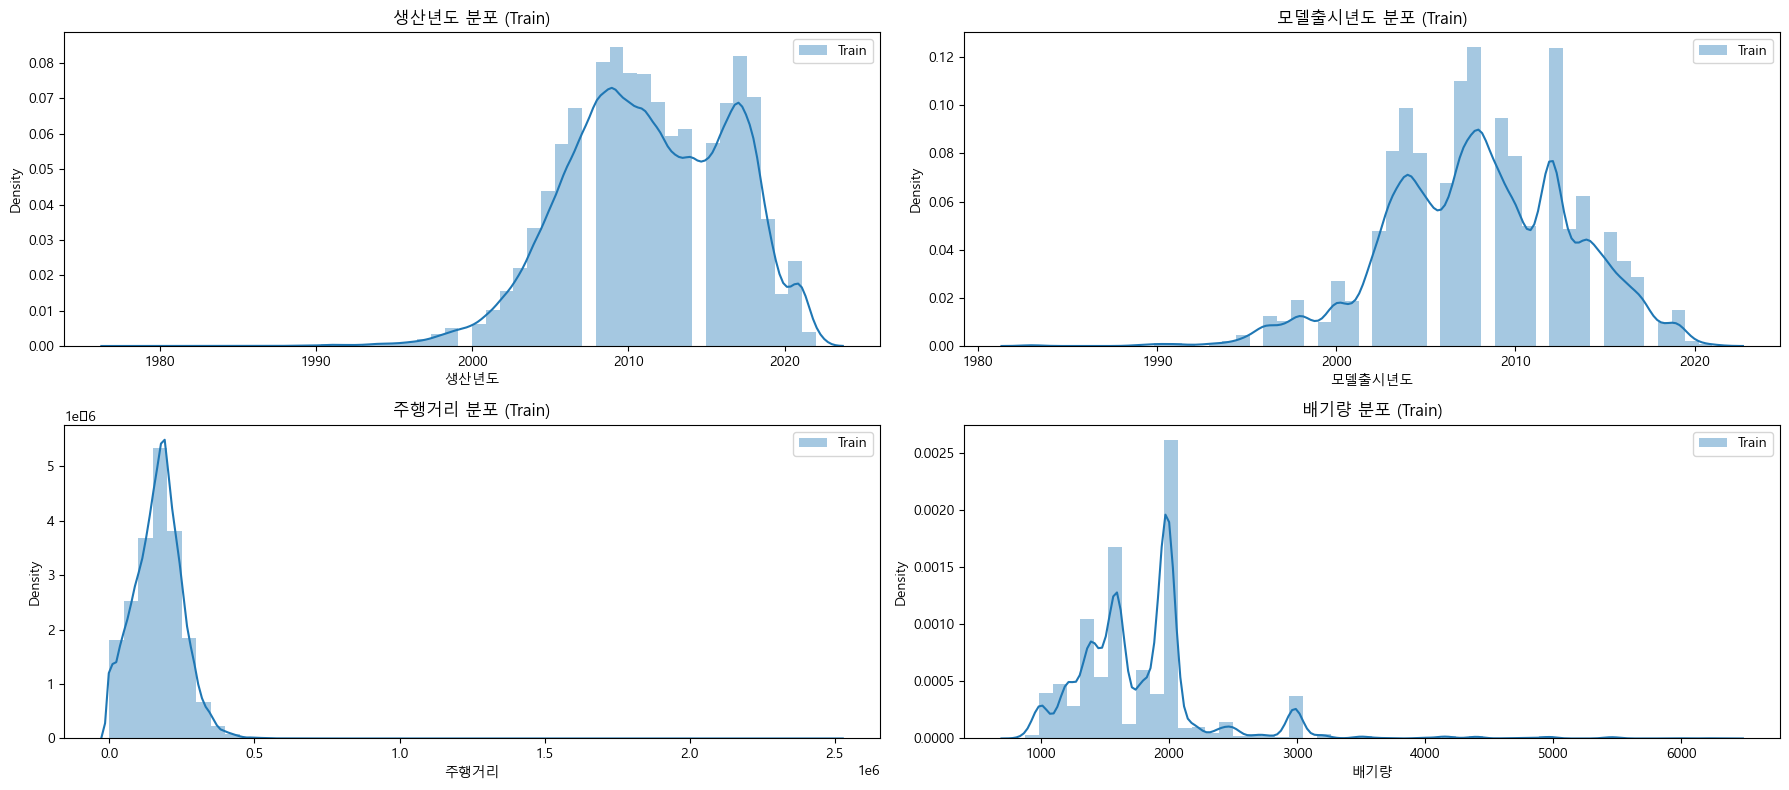

In [16]:
plot_histograms(tr[numeric_cols], '가격', 2)

## 배기량별 구분(차 사이즈, 엔진 기통), 자동차세 추가

In [17]:
lst = []
for val in tqdm(tr['배기량']):
    if val > 2000:
        lst.append('대형')
    elif val > 1600:
        lst.append('중형')
    elif val > 1000:
        lst.append('소형')
    else:
        lst.append('경형')

tr['배기량별 구분'] = lst

100%|██████████| 57920/57920 [00:00<00:00, 4662842.37it/s]


In [18]:
lst = []
for val in tqdm(te['배기량']):
    if val > 2000:
        lst.append('대형')
    elif val > 1600:
        lst.append('중형')
    elif val > 1000:
        lst.append('소형')
    else:
        lst.append('경형')

te['배기량별 구분'] = lst

100%|██████████| 14480/14480 [00:00<00:00, 4829319.49it/s]


In [19]:
tr['연간 자동차세'] = 0
tr.loc[tr['배기량별 구분']=='경형','연간 자동차세'] = tr['배기량'] * 90
tr.loc[tr['배기량별 구분']=='소형','연간 자동차세'] = tr['배기량'] * 140
tr.loc[np.logical_or(tr['배기량별 구분']=='중형', tr['배기량별 구분']=='대형'),'연간 자동차세'] = tr['배기량'] * 220

te['연간 자동차세'] = 0
te.loc[te['배기량별 구분']=='경형','연간 자동차세'] = te['배기량'] * 90
te.loc[te['배기량별 구분']=='소형','연간 자동차세'] = te['배기량'] * 140
te.loc[np.logical_or(te['배기량별 구분']=='중형', te['배기량별 구분']=='대형'),'연간 자동차세'] = te['배기량'] * 220

tr['지방교육세'] = tr['연간 자동차세'] * .3
te['지방교육세'] = te['연간 자동차세'] * .3

In [20]:
tr['총 자동차세'] = tr['연간 자동차세'] + tr['지방교육세']
te['총 자동차세'] = te['연간 자동차세'] + te['지방교육세']

In [21]:
lst = []
for val in tqdm(tr['배기량']):
    if val > 3800:
        lst.append('8기통')
    elif val > 3000:
        lst.append('6기통')
    elif val > 1400:
        lst.append('4기통')
    else:
        lst.append('3기통')

tr['배기량별 구분2'] = lst

100%|██████████| 57920/57920 [00:00<00:00, 4137301.81it/s]


In [22]:
lst = []
for val in tqdm(te['배기량']):
    if val > 3800:
        lst.append('8기통')
    elif val > 3000:
        lst.append('6기통')
    elif val > 1400:
        lst.append('4기통')
    else:
        lst.append('3기통')

te['배기량별 구분2'] = lst

100%|██████████| 14480/14480 [00:00<00:00, 4830087.63it/s]


## 생산 이후, 출시 이후 경과 시간 추가

In [23]:
tr['생산이후'] = 2023 - tr['생산년도']
tr['모델출시이후'] = 2023 - tr['모델출시년도']

te['생산이후'] = 2023 - te['생산년도']
te['모델출시이후'] = 2023 - te['모델출시년도']

## 자동차세 할인 여부, 할인 후 자동차세 추가

In [24]:
tr['자동차세 할인 여부'] = 0
tr.loc[tr['생산이후']>=3,'자동차세 할인 여부'] = 1

te['자동차세 할인 여부'] = 0
te.loc[te['생산이후']>=3,'자동차세 할인 여부'] = 1

tr['할인 후 자동차세'] = 0
tr.loc[tr['생산이후']>=3,'할인 후 자동차세'] = (tr['연간 자동차세'] + tr['지방교육세'])*(1 - (tr['생산이후']-2)*.05)
tr.loc[tr['생산이후']>=13,'할인 후 자동차세'] = (tr['연간 자동차세'] + tr['지방교육세'])*.5

te['할인 후 자동차세'] = 0
te.loc[te['생산이후']>=3,'할인 후 자동차세'] = (te['연간 자동차세'] + te['지방교육세'])*(1 - (te['생산이후']-2)*.05)
te.loc[te['생산이후']>=13,'할인 후 자동차세'] = (te['연간 자동차세'] + te['지방교육세'])*.5

## 일반보증, 엔진보증 추가(3년/6만km, 5년/10만km)

In [25]:
tr['일반보증'] = 0
tr.loc[np.logical_or(tr['생산이후']<=3, tr['주행거리']<=60000),'일반보증'] = 1

te['일반보증'] = 0
te.loc[np.logical_or(te['생산이후']<=3, te['주행거리']<=60000),'일반보증'] = 1

tr['엔진보증'] = 0
tr.loc[np.logical_or(tr['생산이후']<=5, tr['주행거리']<=100000),'엔진보증'] = 1

te['엔진보증'] = 0
te.loc[np.logical_or(te['생산이후']<=5, te['주행거리']<=100000),'엔진보증'] = 1

In [26]:
def plot_distribution(df, hue, title='', drop_cols=[]):
    cols = df.columns.drop([hue] + drop_cols)
    n_cols = 3
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue) # sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        ax.set_title(f'{var_name} 분포')

    fig.suptitle(f'{title} 분포 Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

## 범주형 변수 별 수치형 변수의 분포 확인_1

In [39]:
numeric_cols = []
object_cols = []

for col in tqdm(tr.columns):
    if is_numeric_dtype(tr[col]) and col != '가격':
        numeric_cols.append(col)
    elif not(is_numeric_dtype(tr[col])) and col != '가격':
        object_cols.append(col)

print('수치형 변수 : ', numeric_cols)
print('범주형 변수 : ', object_cols)

100%|██████████| 21/21 [00:00<00:00, 20976.51it/s]

수치형 변수 :  ['생산년도', '모델출시년도', '주행거리', '배기량', '연간 자동차세', '지방교육세', '총 자동차세', '생산이후', '모델출시이후', '자동차세 할인 여부', '할인 후 자동차세', '일반보증', '엔진보증']
범주형 변수 :  ['브랜드', '차량모델명', '판매도시', '판매구역', '연료', '배기량별 구분', '배기량별 구분2']


In [41]:
object_cols.append('자동차세 할인 여부')
object_cols.append('일반보증')
object_cols.append('엔진보증')

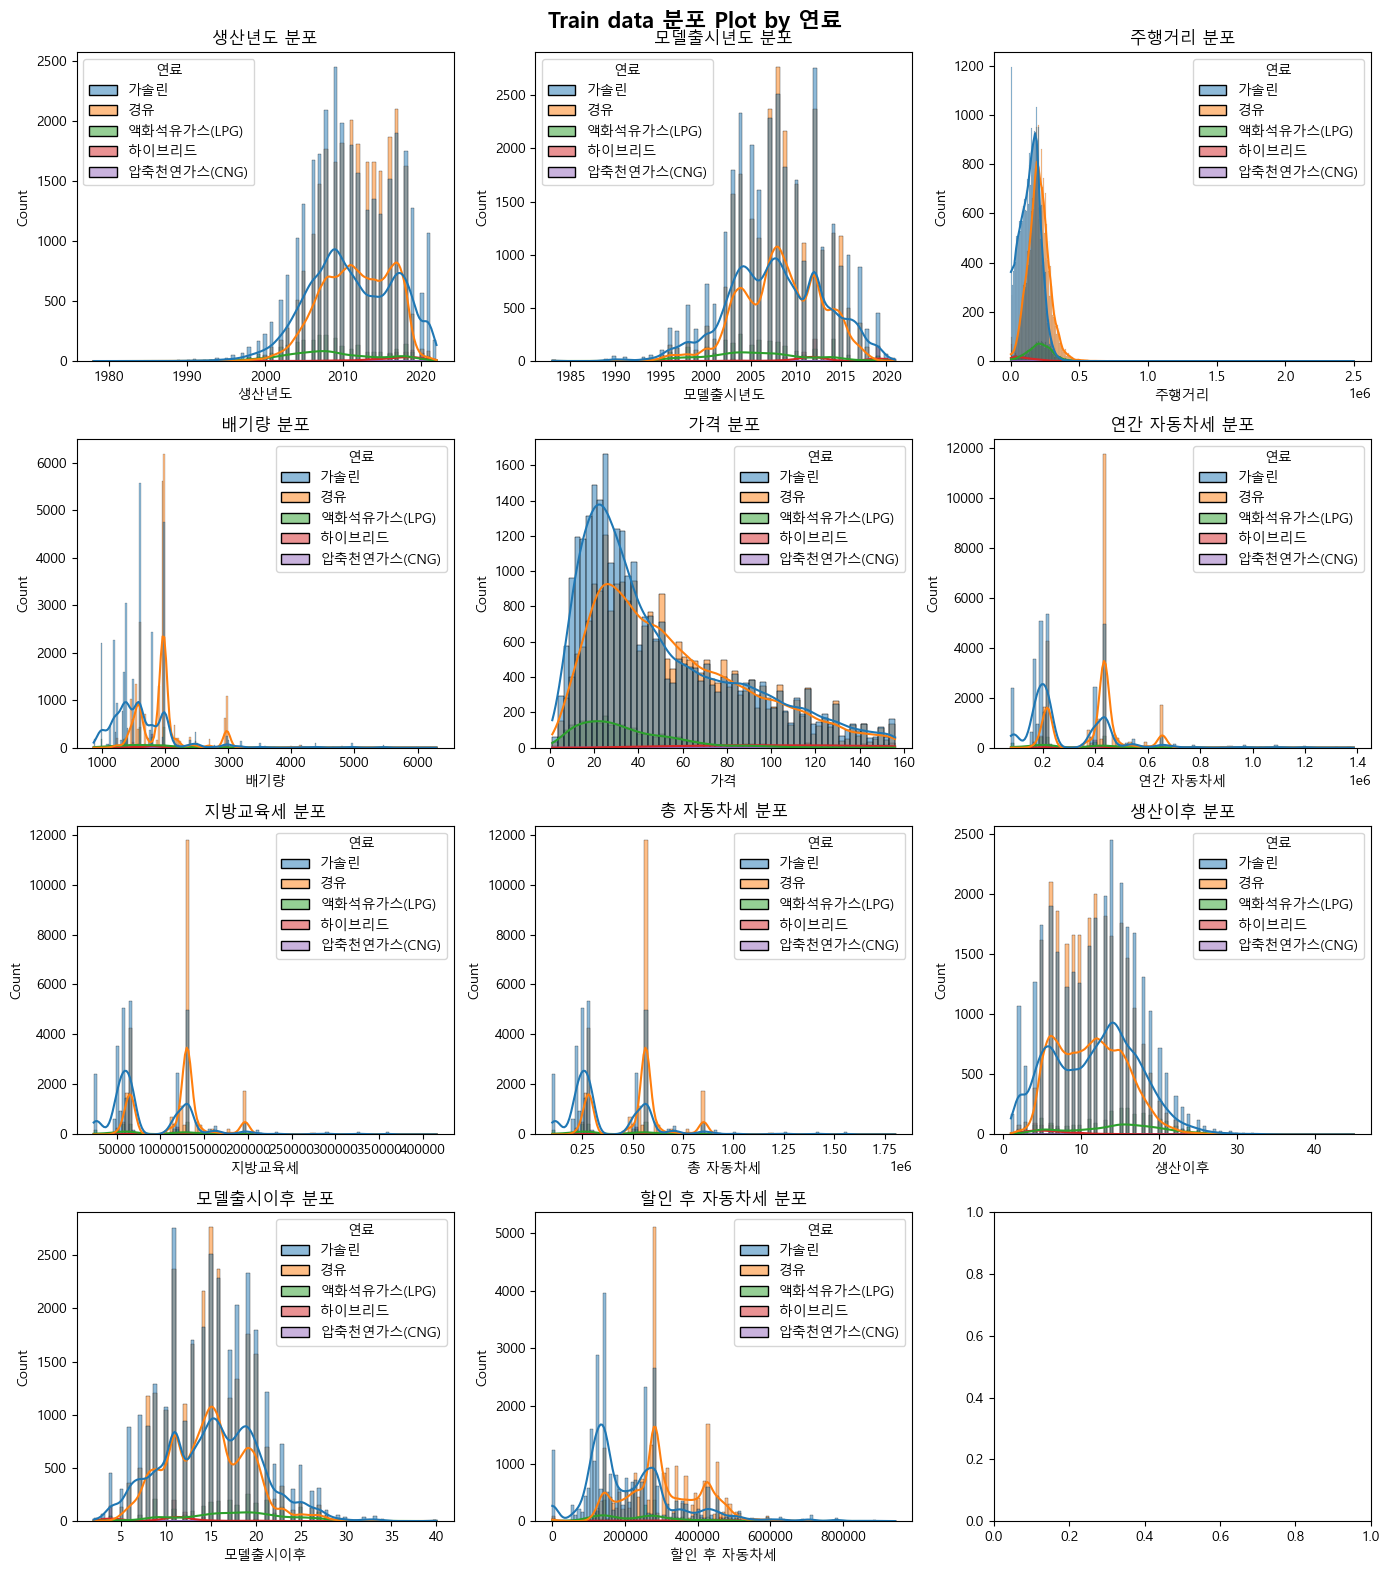

In [42]:
plot_distribution(tr, hue='연료', title='Train data', drop_cols=object_cols)

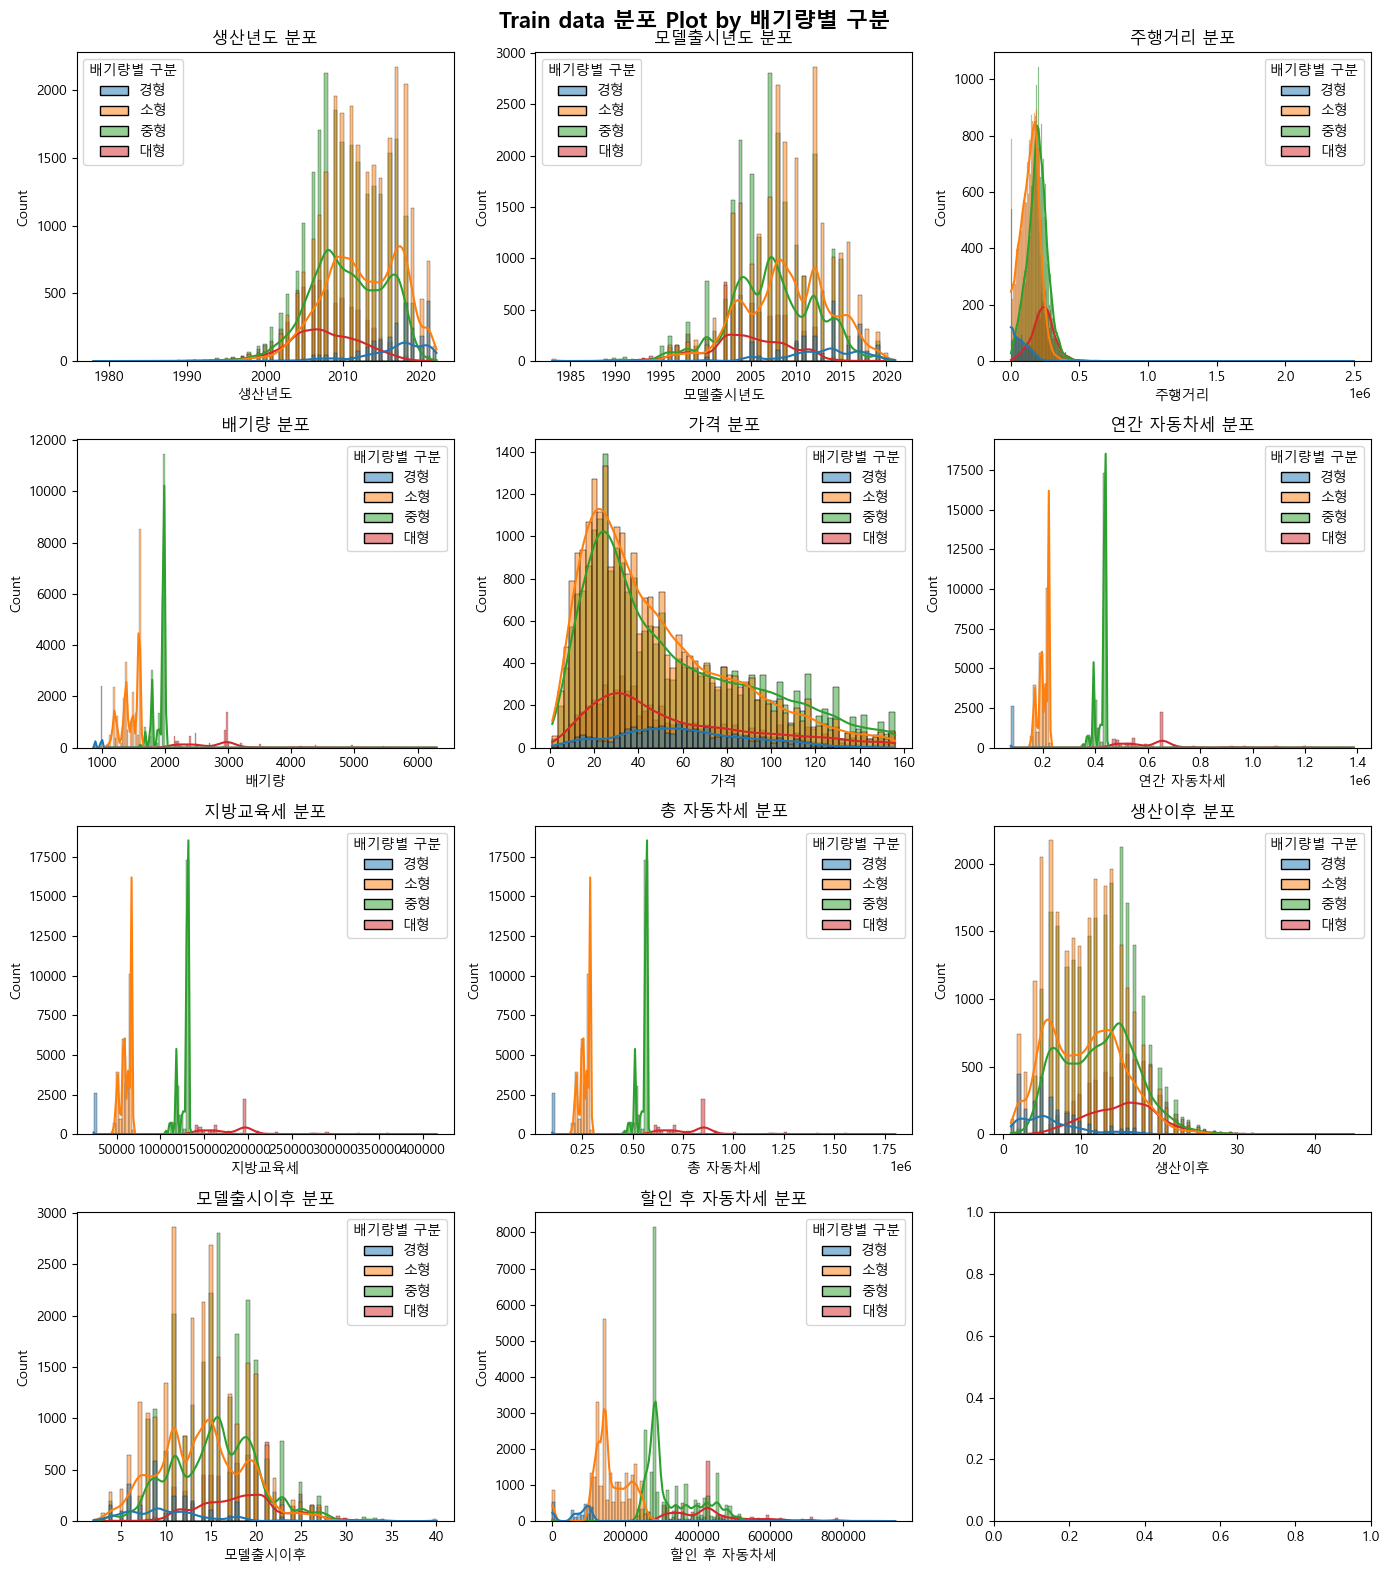

In [43]:
plot_distribution(tr, hue='배기량별 구분', title='Train data', drop_cols=object_cols)

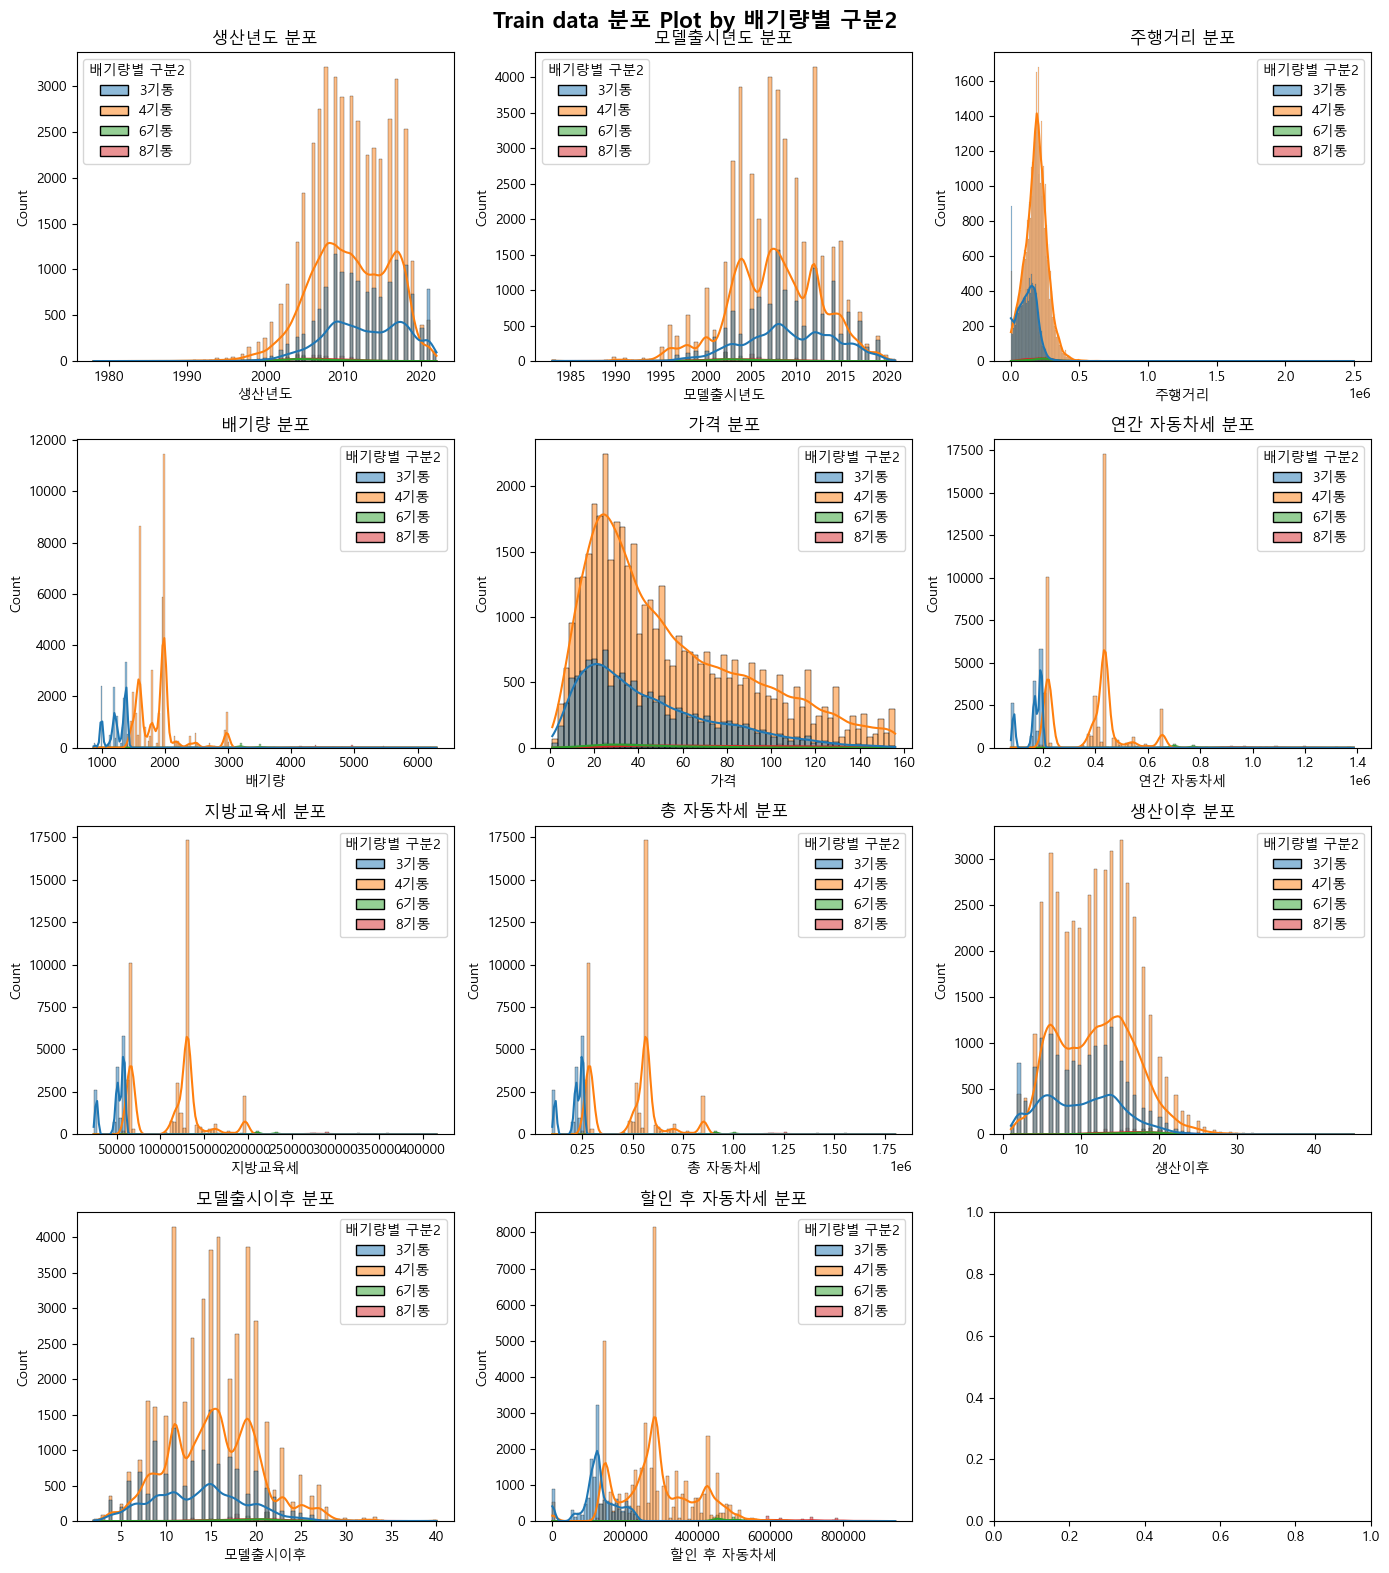

In [44]:
plot_distribution(tr, hue='배기량별 구분2', title='Train data', drop_cols=object_cols)

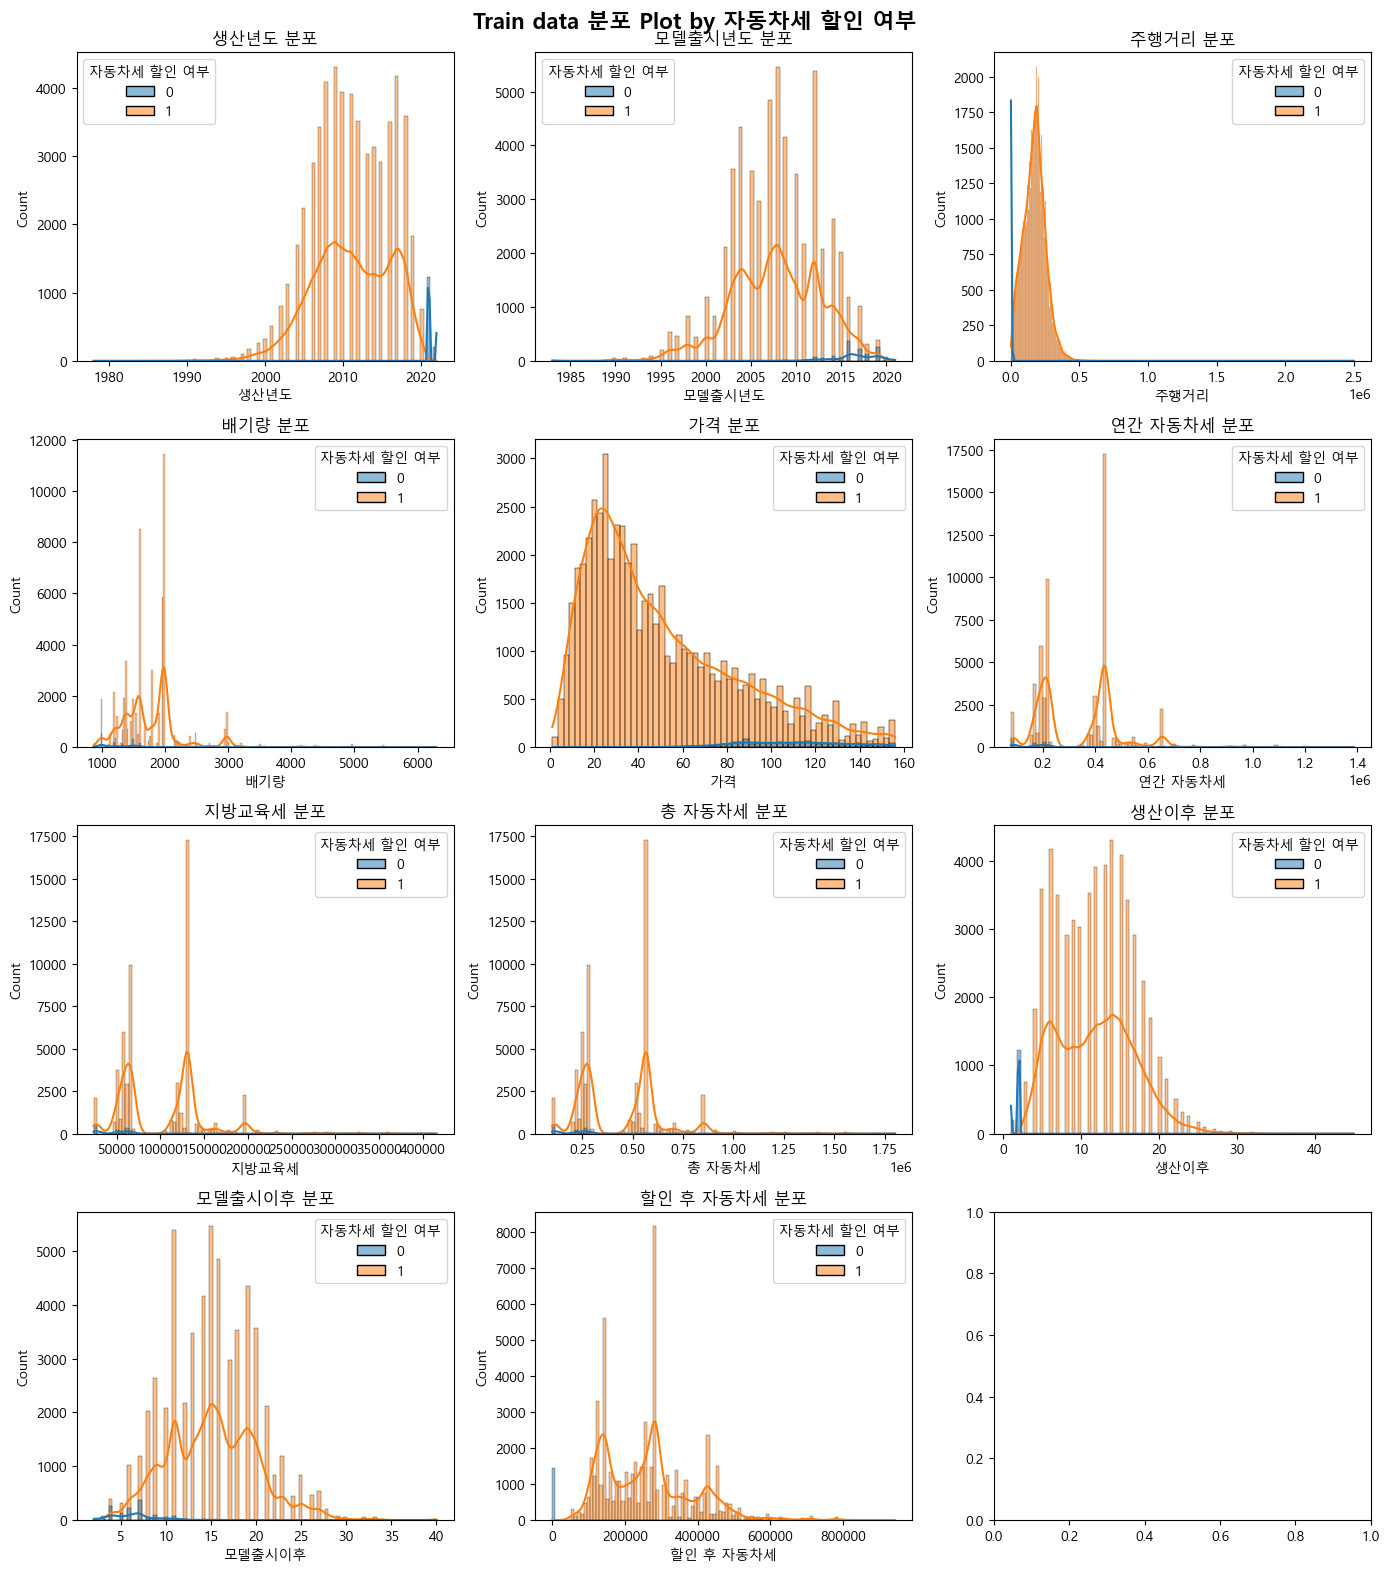

In [45]:
plot_distribution(tr, hue='자동차세 할인 여부', title='Train data', drop_cols=object_cols)

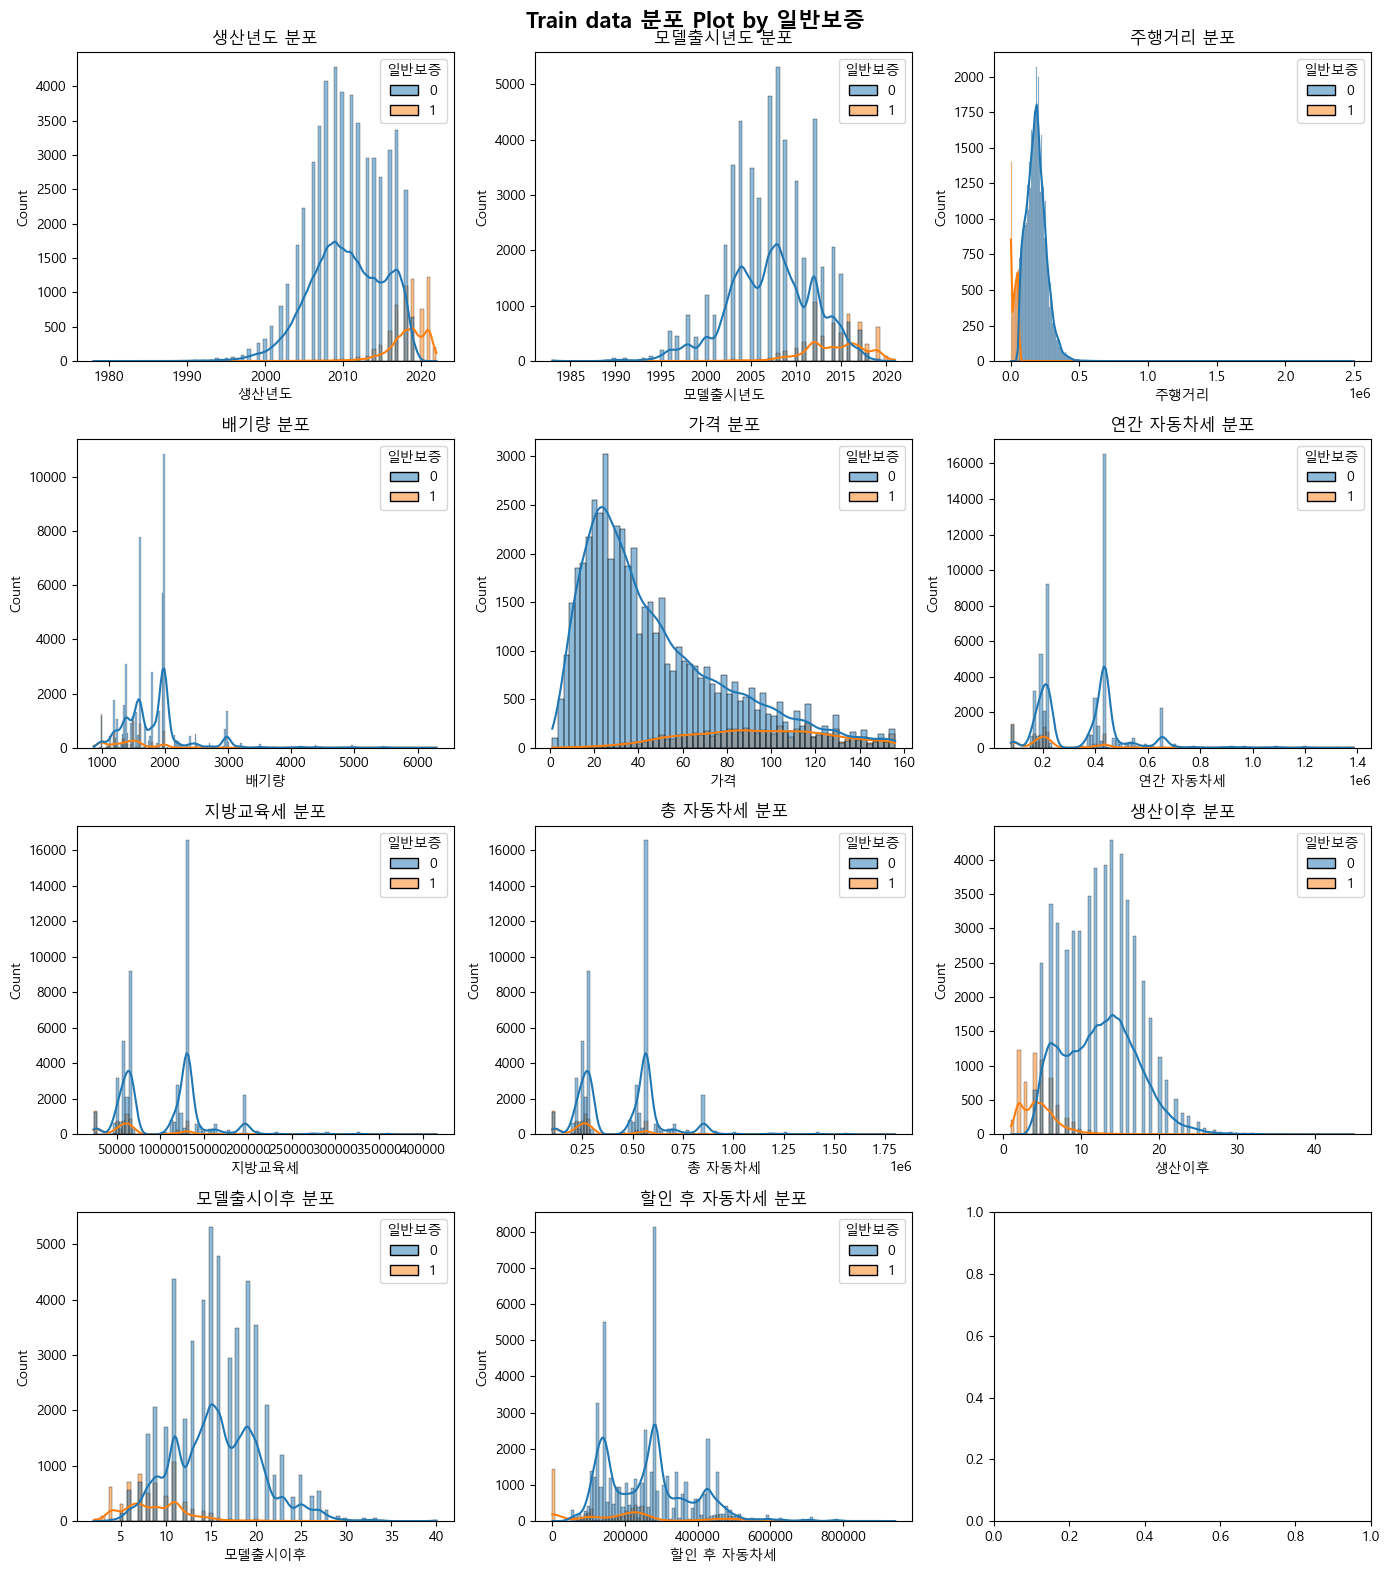

In [46]:
plot_distribution(tr, hue='일반보증', title='Train data', drop_cols=object_cols)

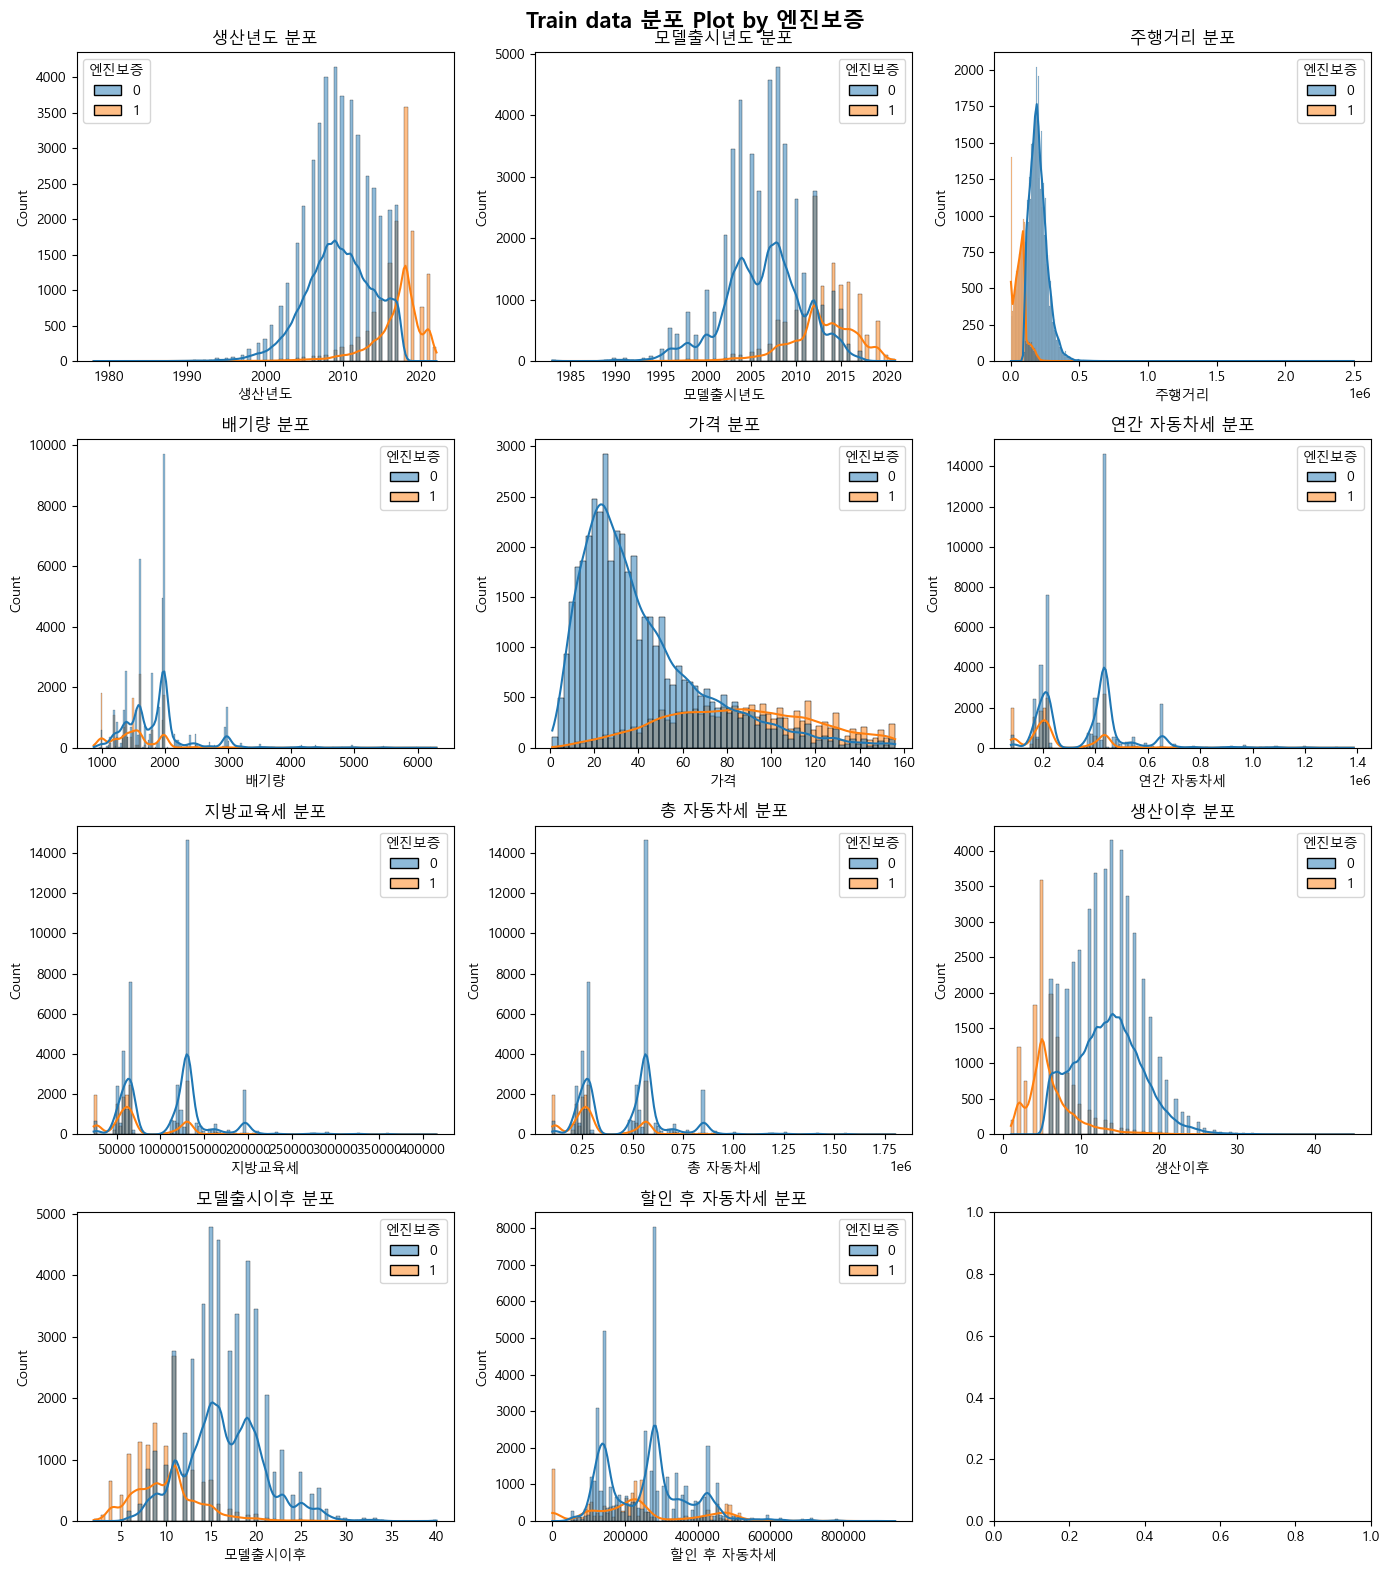

In [47]:
plot_distribution(tr, hue='엔진보증', title='Train data', drop_cols=object_cols)

## 주행거리별 구분 추가

In [48]:
tr['주행거리별 구분'] = 0
tr.loc[np.logical_and(tr['주행거리']>=0, tr['주행거리']<=50000),'주행거리별 구분'] = '양호'
tr.loc[np.logical_and(tr['주행거리']>50000, tr['주행거리']<=100000),'주행거리별 구분'] = '좀많음'
tr.loc[np.logical_and(tr['주행거리']>100000, tr['주행거리']<=200000),'주행거리별 구분'] = '많음'
tr.loc[tr['주행거리']>200000,'주행거리별 구분'] = '아주많음'

te['주행거리별 구분'] = 0
te.loc[np.logical_and(te['주행거리']>=0, te['주행거리']<=50000),'주행거리별 구분'] = '양호'
te.loc[np.logical_and(te['주행거리']>50000, te['주행거리']<=100000),'주행거리별 구분'] = '좀많음'
te.loc[np.logical_and(te['주행거리']>100000, te['주행거리']<=200000),'주행거리별 구분'] = '많음'
te.loc[tr['주행거리']>200000,'주행거리별 구분'] = '아주많음'

## 범주형 변수 별 수치형 변수의 분포 확인_2

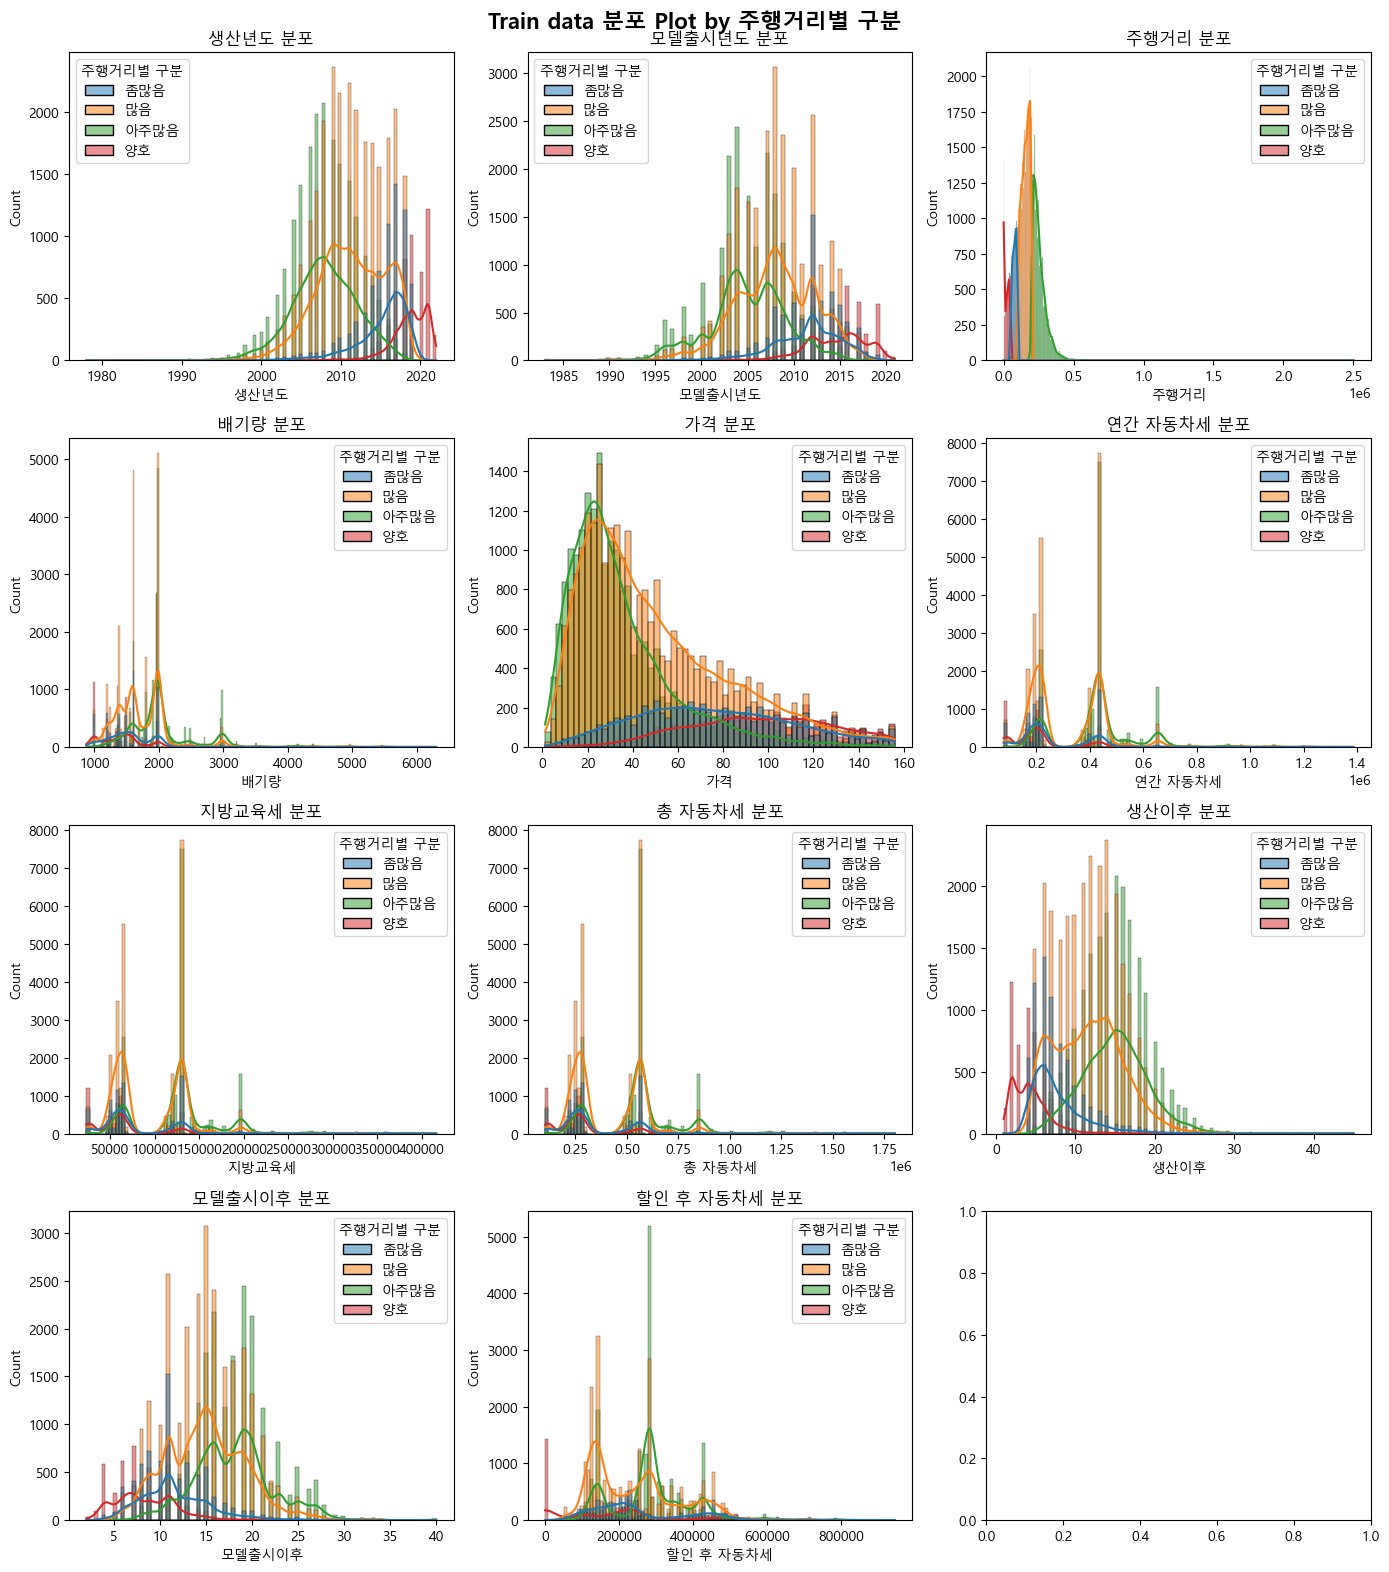

In [49]:
plot_distribution(tr, hue='주행거리별 구분', title='Train data', drop_cols=object_cols)